In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import json
import h5py

import windIO
import wind
import windWT as wt
import windCAD
import windOF as foam

import winsound

from matplotlib.ticker import FuncFormatter

## Basic definitions

### Scaling
The geometric length scale is decided based on the optimal fitting the model in the wind tunnel.
$$ \lambda_L=1:50 $$

The velocity scale is calculated by assuming the design wind speed of 25 m/s. 
$$ U_{10}=25 m/s $$

Assuming an approximate roof height wind speed at the model scale to be $U_H^{WT}=10m/s$ (will be updated after the test) and considering the roof height ($H=8m/s$) close enough to $10m$:
$$ \lambda_V= \frac{U_H^{WT}}{U_{H}}=**varies** $$

Thus, the time scale is:
$$ \lambda_T = \frac{\lambda_L}{\lambda_V} = **varies** $$

$\implies$ the model scale duration equivalent to the full-scale $1hr$ is ???.

In [46]:
dir_wtVl_tngE2 = r"D:/tempData_depot/simData_CandC/wt_tngE2/"
dir_wtVl_tngE3 = r"D:/tempData_depot/simData_CandC/wt_tngE3/"

runIDs = ['p1', 'p2', 'p3', 'p4', 'p5',]

dir_wtCp_tngE2 = [r"E:/TNG/rawHFPI/tngE2"+x+"/" for x in runIDs]
dir_wtCp_tngE3 = [r"E:/TNG/rawHFPI/tngE3"+x+"/" for x in runIDs]

saveFigs = False
figDir = r"D:/tempData_depot/simData_CandC/__plots/blwt/"
if not os.path.exists(figDir):
    os.makedirs(figDir)

In [47]:
B = 0.2744
D = 0.183
lScl=1/50.0

Hr = 0.08  # ridge height
roofSlope = np.rad2deg(np.arctan(0.25/12))  # roof slope
He = Hr - D/2.0*np.sin(np.deg2rad(roofSlope))  # eaves height
Havg = np.mean([Hr, He])
H = Havg  # average roof height
print("Hr = {:.5g} m, He = {:.5g} m, Havg = {:.5g} m".format(Hr, He, Havg))

areaFactor_toFSm2 = (1/lScl**2)   # convert mm2 to m2 and normalize by the square of the length scale

badTaps = None
# badTaps = [1316, 1807, 2609,]


Hr = 0.08 m, He = 0.078094 m, Havg = 0.079047 m


## Building Geometry

In [48]:
tapFile = r"D:/tempData_depot/simData_CandC/tngTapDefinition.csv"
data = pd.read_csv(tapFile)

faceID = [1,2,3,4,5,6]
name = ['Roof_1','Roof_2','Wall_1','Wall_2','Wall_3','Wall_4']
note = ['','','','','','']
origin = [[0,0,0.08],
          [0,-0.0915,0.07809375],
          [-0.1372,0,0],
          [0,-0.0915,0],
          [0.1372,0,0],
          [0,0.0915,0],]
basisVectors = [[[1,0,0],[0,0.999783057,0.020828814],[0,-0.020828814,0.999783057]],
                [[1,0,0],[0,0.999783057,-0.020828814],[0,0.020828814,0.999783057]],
                [[0,0,-1],[-1,0,0],[0,1,0]],
                [[1,0,0],[0,0,-1],[0,1,0]],
                [[0,0,1],[1,0,0],[0,1,0]],
                [[-1,0,0],[0,0,1],[0,1,0]],]

origin_plt = [[0, 0],
              [0, 0],
              [0, 0],
              [0, 0],
              [0, 0],
              [0, 0],
              ]

basisVectors_plt = [[[0, 1], [-1, 0]],
                    [[0, 1], [-1, 0]],
                    [[0, 1], [-1, 0]],
                    [[0, 1], [-1, 0]],
                    [[0, 1], [-1, 0]],
                    [[0, 1], [-1, 0]],
                    ]
vertices = [[[-0.091519855,-0.1372],[0,-0.1372],[0,0.1372],[-0.091519855,0.1372],[-0.091519855,-0.1372]],
            [[0,-0.1372],[0.091519855,-0.1372],[0.091519855,0.1372],[0,0.1372],[0,-0.1372]],
            [[-0.0915,-0.2332],[0.0915,-0.2332],[0.0915,-0.15510625],[0,-0.1532],[-0.0915,-0.15510625],[-0.0915,-0.2332]],
            [[0.107519855,-0.1372],[0.185613605,-0.1372],[0.185613605,0.1372],[0.107519855,0.1372],[0.107519855,-0.1372]],
            [[-0.0915,0.2332],[0.0915,0.2332],[0.0915,0.15510625],[0,0.1532],[-0.0915,0.15510625],[-0.0915,0.2332]],
            [[-0.107519855,-0.1372],[-0.185613605,-0.1372],[-0.185613605,0.1372],[-0.107519855,0.1372],[-0.107519855,-0.1372]],]



In [49]:
# Zone Dict definitions

zoneDict_NBCC = [
        {    # Face 1
            0:['NBCC 2020', 'Zone c', np.array([[-0.091519855,-0.1372],[-0.071519855,-0.1372],[-0.071519855,-0.1172],[-0.091519855,-0.1172],[-0.091519855,-0.1372]])],
            1:['NBCC 2020', 'Zone c', np.array([[-0.091519855,0.1172],[-0.071519855,0.1172],[-0.071519855,0.1372],[-0.091519855,0.1372],[-0.091519855,0.1172]])],
            2:['NBCC 2020', 'Zone s', np.array([[-0.071519855,-0.1372],[0,-0.1372],[0,-0.1172],[-0.071519855,-0.1172],[-0.071519855,-0.1372]])],
            3:['NBCC 2020', 'Zone s', np.array([[-0.091519855,-0.1172],[-0.071519855,-0.1172],[-0.071519855,0.1172],[-0.091519855,0.1172],[-0.091519855,-0.1172]])],
            4:['NBCC 2020', 'Zone s', np.array([[-0.071519855,0.1172],[0,0.1172],[0,0.1372],[-0.071519855,0.1372],[-0.071519855,0.1172]])],
            5:['NBCC 2020', 'Zone r', np.array([[-0.071519855,-0.1172],[0,-0.1172],[0,0.1172],[-0.071519855,0.1172],[-0.071519855,-0.1172]])],
        },
        {   # Face 2
            0:['NBCC 2020', 'Zone c', np.array([[0.091519855,-0.1372],[0.071519855,-0.1372],[0.071519855,-0.1172],[0.091519855,-0.1172],[0.091519855,-0.1372]])],
            1:['NBCC 2020', 'Zone c', np.array([[0.091519855,0.1172],[0.071519855,0.1172],[0.071519855,0.1372],[0.091519855,0.1372],[0.091519855,0.1172]])],
            2:['NBCC 2020', 'Zone s', np.array([[0.071519855,-0.1372],[0,-0.1372],[0,-0.1172],[0.071519855,-0.1172],[0.071519855,-0.1372]])],
            3:['NBCC 2020', 'Zone s', np.array([[0.091519855,-0.1172],[0.071519855,-0.1172],[0.071519855,0.1172],[0.091519855,0.1172],[0.091519855,-0.1172]])],
            4:['NBCC 2020', 'Zone s', np.array([[0.071519855,0.1172],[0,0.1172],[0,0.1372],[0.071519855,0.1372],[0.071519855,0.1172]])],
            5:['NBCC 2020', 'Zone r', np.array([[0.071519855,-0.1172],[0,-0.1172],[0,0.1172],[0.071519855,0.1172],[0.071519855,-0.1172]])],
        },
        {   # Face 3
            0:['NBCC 2020', 'Zone e', np.array([[-0.0915,-0.2332],[-0.0715,-0.2332],[-0.0715,-0.154689583],[-0.0915,-0.15510625],[-0.0915,-0.2332]])],
            1:['NBCC 2020', 'Zone e', np.array([[0.0715,-0.2332],[0.0915,-0.2332],[0.0915,-0.15510625],[0.0715,-0.154689583],[0.0715,-0.2332]])],
            2:['NBCC 2020', 'Zone w', np.array([[-0.0715,-0.2332],[0.0715,-0.2332],[0.0715,-0.154689583],[0,-0.1532],[-0.0715,-0.154689583],[-0.0715,-0.2332]])],
        },
        {   # Face 4
            0:['NBCC 2020', 'Zone e', np.array([[0.107519855,-0.1372],[0.185613605,-0.1372],[0.185613605,-0.1172],[0.107519855,-0.1172],[0.107519855,-0.1372]])],
            1:['NBCC 2020', 'Zone e', np.array([[0.107519855,0.1172],[0.185613605,0.1172],[0.185613605,0.1372],[0.107519855,0.1372],[0.107519855,0.1172]])],
            2:['NBCC 2020', 'Zone w', np.array([[0.107519855,-0.1172],[0.185613605,-0.1172],[0.185613605,0.1172],[0.107519855,0.1172],[0.107519855,-0.1172]])],
        },
        {   # Face 5
            0:['NBCC 2020', 'Zone e', np.array([[-0.0915,0.2332],[-0.0715,0.2332],[-0.0715,0.154689583],[-0.0915,0.15510625],[-0.0915,0.2332]])],
            1:['NBCC 2020', 'Zone e', np.array([[0.0715,0.2332],[0.0915,0.2332],[0.0915,0.15510625],[0.0715,0.154689583],[0.0715,0.2332]])],
            2:['NBCC 2020', 'Zone w', np.array([[-0.0715,0.2332],[0.0715,0.2332],[0.0715,0.154689583],[0,0.1532],[-0.0715,0.154689583],[-0.0715,0.2332]])],
        },
        {   # Face 6
            0:['NBCC 2020', 'Zone e', np.array([[-0.107519855,-0.1372],[-0.185613605,-0.1372],[-0.185613605,-0.1172],[-0.107519855,-0.1172],[-0.107519855,-0.1372]])],
            1:['NBCC 2020', 'Zone e', np.array([[-0.107519855,0.1172],[-0.185613605,0.1172],[-0.185613605,0.1372],[-0.107519855,0.1372],[-0.107519855,0.1172]])],
            2:['NBCC 2020', 'Zone w', np.array([[-0.107519855,-0.1172],[-0.185613605,-0.1172],[-0.185613605,0.1172],[-0.107519855,0.1172],[-0.107519855,-0.1172]])],
        },
]

zoneDict_ASCE = [
        {    # Face 1
            0:['ASCE 7-22', 'Zone 3', np.array([[-0.0435, 0.1372], [-0.0915, 0.1372], [-0.0915, 0.0892], [-0.0755, 0.0892], [-0.0755, 0.1212], [-0.0435, 0.1212], [-0.0435, 0.1372], ])],
            1:['ASCE 7-22', 'Zone 3', np.array([[-0.0915, -0.0892], [-0.0915, -0.1372], [-0.0435, -0.1372], [-0.0435, -0.1212], [-0.0755, -0.1212], [-0.0755, -0.0892], [-0.0915, -0.0892], ])],
            2:['ASCE 7-22', 'Zone 2', np.array([[0, 0.1372], [-0.0435, 0.1372], [-0.0435, 0.1212], [-0.0755, 0.1212], [-0.0755, 0.0892], [-0.0915, 0.0892], [-0.0915, -0.0892], 
                                                [-0.0755, -0.0892], [-0.0755, -0.1212], [-0.0435, -0.1212], [-0.0435, -0.1372], [0, -0.1372], [0, -0.0892], [-0.0435, -0.0892], 
                                                [-0.0435, 0.0892], [0, 0.0892], [0, 0.1372], ])],
            3:['ASCE 7-22', 'Zone 1', np.array([[0, 0.0892], [-0.0435, 0.0892], [-0.0435, -0.0892], [0, -0.0892], [0, 0.0892], ])],
        },
        {   # Face 2
            0:['ASCE 7-22', 'Zone 3', np.array([[0.0435, 0.1372], [0.0915, 0.1372], [0.0915, 0.0892], [0.0755, 0.0892], [0.0755, 0.1212], [0.0435, 0.1212], [0.0435, 0.1372], ])],
            1:['ASCE 7-22', 'Zone 3', np.array([[0.0915, -0.0892], [0.0915, -0.1372], [0.0435, -0.1372], [0.0435, -0.1212], [0.0755, -0.1212], [0.0755, -0.0892], [0.0915, -0.0892], ])],
            2:['ASCE 7-22', 'Zone 2', np.array([[0, 0.1372], [0.0435, 0.1372], [0.0435, 0.1212], [0.0755, 0.1212], [0.0755, 0.0892], [0.0915, 0.0892], [0.0915, -0.0892], 
                                                [0.0755, -0.0892], [0.0755, -0.1212], [0.0435, -0.1212], [0.0435, -0.1372], [0, -0.1372], [0, -0.0892], [0.0435, -0.0892], 
                                                [0.0435, 0.0892], [0, 0.0892], [0, 0.1372], ])],
            3:['ASCE 7-22', 'Zone 1', np.array([[0, 0.0892], [0.0435, 0.0892], [0.0435, -0.0892], [0, -0.0892], [0, 0.0892], ])],
        },
        {   # Face 3
            0:['ASCE 7-22', 'Zone 4', np.array([[-0.0715,-0.2332],[0.0715,-0.2332],[0.0715,-0.154689583],[0,-0.1532],[-0.0715,-0.154689583],[-0.0715,-0.2332]])],
            1:['ASCE 7-22', 'Zone 5', np.array([[-0.0915,-0.2332],[-0.0715,-0.2332],[-0.0715,-0.154689583],[-0.0915,-0.15510625],[-0.0915,-0.2332]])],
            2:['ASCE 7-22', 'Zone 5', np.array([[0.0715,-0.2332],[0.0915,-0.2332],[0.0915,-0.15510625],[0.0715,-0.154689583],[0.0715,-0.2332]])],
        },
        {   # Face 4
            0:['ASCE 7-22', 'Zone 5', np.array([[0.107519855,-0.1372],[0.185613605,-0.1372],[0.185613605,-0.1172],[0.107519855,-0.1172],[0.107519855,-0.1372]])],
            1:['ASCE 7-22', 'Zone 5', np.array([[0.107519855,0.1172],[0.185613605,0.1172],[0.185613605,0.1372],[0.107519855,0.1372],[0.107519855,0.1172]])],
            2:['ASCE 7-22', 'Zone 4', np.array([[0.107519855,-0.1172],[0.185613605,-0.1172],[0.185613605,0.1172],[0.107519855,0.1172],[0.107519855,-0.1172]])],
        },
        {   # Face 5
            0:['ASCE 7-22', 'Zone 5', np.array([[-0.0915,0.2332],[-0.0715,0.2332],[-0.0715,0.154689583],[-0.0915,0.15510625],[-0.0915,0.2332]])],
            1:['ASCE 7-22', 'Zone 5', np.array([[0.0715,0.2332],[0.0915,0.2332],[0.0915,0.15510625],[0.0715,0.154689583],[0.0715,0.2332]])],
            2:['ASCE 7-22', 'Zone 4', np.array([[-0.0715,0.2332],[0.0715,0.2332],[0.0715,0.154689583],[0,0.1532],[-0.0715,0.154689583],[-0.0715,0.2332]])],
        },
        {   # Face 6
            0:['ASCE 7-22', 'Zone 5', np.array([[-0.107519855,-0.1372],[-0.185613605,-0.1372],[-0.185613605,-0.1172],[-0.107519855,-0.1172],[-0.107519855,-0.1372]])],
            1:['ASCE 7-22', 'Zone 5', np.array([[-0.107519855,0.1172],[-0.185613605,0.1172],[-0.185613605,0.1372],[-0.107519855,0.1372],[-0.107519855,0.1172]])],
            2:['ASCE 7-22', 'Zone 4', np.array([[-0.107519855,-0.1172],[-0.185613605,-0.1172],[-0.185613605,0.1172],[-0.107519855,0.1172],[-0.107519855,-0.1172]])],
        },
]

# file = caseDir+'NBCC_zoneDict.json'
# with open(file, 'w') as f:
#     json.dump(zoneDict,f, indent=4, separators=(',', ':'))

In [50]:
# nominalPanelAreas=[1.0e-4, 2.45e-4, 4.8e-4, 7.1e-4, 1e-3], #[5e-5, 8e-5, 1.5e-4, 5e-4]
# nominalPanelAreas=[4.4e-5, 8.15e-5, 1.3e-4, 5e-4, 6.8e-4, 1.3e-3,]  # Final! All are tested. 1.3e-3 results in blunt edge zones in the walls but no error.
nominalPanelAreas=[4.4e-5, 8.15e-5, 1.3e-4, 5.25e-4, 6.8e-4, 1.3e-3,]  # 5e-4 causes problems in ASCE 7-22 zone 2 
# nominalPanelAreas=[1.3e-3,]
# nominalPanelAreas=[4.8e-4, 7.2e-4, 1e-3]

faces_NBCC = []
for i,f in enumerate(faceID):
    idx = data.index[data.faceID == f]
    tapCoords = np.transpose(np.array([data.x[idx], data.y[idx]]))
    tapNos = np.array(data.tapNo[idx],dtype=int)
    idxOrig = idx

    fc = windCAD.face(
                name=name[i],
                ID=f,
                origin=origin[i],
                basisVectors=basisVectors[i],
                origin_plt=origin_plt[i],
                basisVectors_plt=basisVectors_plt[i],
                vertices=vertices[i],
                tapNo=tapNos,
                tapIdx=idxOrig,
                tapName=None,
                tapCoord=tapCoords,
                zoneDict=zoneDict_NBCC[i],
                nominalPanelAreas=nominalPanelAreas,
                numOfNominalPanelAreas=3,
                badTaps=badTaps,
                allBldgTaps=np.array(data.tapNo,dtype=int),
                )
    # fc.plot(figSize=[20,15], overlayPanels=True, overlayTaps=True, overlayTribs=True, overlayZones=True)
    faces_NBCC.append(fc)

faces_ASCE = []
for i,f in enumerate(faceID):
    idx = data.index[data.faceID == f]
    tapCoords = np.transpose(np.array([data.x[idx], data.y[idx]]))
    tapNos = np.array(data.tapNo[idx],dtype=int)
    idxOrig = idx

    fc = windCAD.face(
                name=name[i],
                ID=f,
                origin=origin[i],
                basisVectors=basisVectors[i],
                origin_plt=origin_plt[i],
                basisVectors_plt=basisVectors_plt[i],
                vertices=vertices[i],
                tapNo=tapNos,
                tapIdx=idxOrig,
                tapName=None,
                tapCoord=tapCoords,
                zoneDict=zoneDict_ASCE[i],
                nominalPanelAreas=nominalPanelAreas,
                numOfNominalPanelAreas=3,
                badTaps=badTaps,
                allBldgTaps=np.array(data.tapNo,dtype=int),
                )
    # fc.plot(figSize=[20,15], overlayPanels=True, overlayTaps=True, overlayTribs=True, overlayZones=True)
    faces_ASCE.append(fc)
# file = caseDir+'ttu_bldgGeom.json'
# allFaces.writeToFile(file_basic=file)

Generating panels ...


c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_pol

Done generating panels ...
Error summary in paneling:
{
    "NBCC 2020 -- Zone c": {
        "nom. areas idxs with tiling errors [4.4e-05, 8.15e-05, 0.00013, 0.000525, 0.00068, 0.0013]": [],
        "tap idxs with weight errors": {
            "A=4.4e-05": [],
            "A=8.15e-05": [],
            "A=0.00013": [],
            "A=0.000525": [],
            "A=0.00068": [],
            "A=0.0013": []
        }
    },
    "NBCC 2020 -- Zone s": {
        "nom. areas idxs with tiling errors [4.4e-05, 8.15e-05, 0.00013, 0.000525, 0.00068, 0.0013]": [],
        "tap idxs with weight errors": {
            "A=4.4e-05": [],
            "A=8.15e-05": [],
            "A=0.00013": [],
            "A=0.000525": [],
            "A=0.00068": [],
            "A=0.0013": []
        }
    },
    "NBCC 2020 -- Zone r": {
        "nom. areas idxs with tiling errors [4.4e-05, 8.15e-05, 0.00013, 0.000525, 0.00068, 0.0013]": [],
        "tap idxs with weight errors": {
            "A=4.4e-05": [],
     

c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_pol

Done generating panels ...
Error summary in paneling:
{
    "NBCC 2020 -- Zone c": {
        "nom. areas idxs with tiling errors [4.4e-05, 8.15e-05, 0.00013, 0.000525, 0.00068, 0.0013]": [],
        "tap idxs with weight errors": {
            "A=4.4e-05": [],
            "A=8.15e-05": [],
            "A=0.00013": [],
            "A=0.000525": [],
            "A=0.00068": [],
            "A=0.0013": []
        }
    },
    "NBCC 2020 -- Zone s": {
        "nom. areas idxs with tiling errors [4.4e-05, 8.15e-05, 0.00013, 0.000525, 0.00068, 0.0013]": [],
        "tap idxs with weight errors": {
            "A=4.4e-05": [],
            "A=8.15e-05": [],
            "A=0.00013": [],
            "A=0.000525": [],
            "A=0.00068": [],
            "A=0.0013": []
        }
    },
    "NBCC 2020 -- Zone r": {
        "nom. areas idxs with tiling errors [4.4e-05, 8.15e-05, 0.00013, 0.000525, 0.00068, 0.0013]": [],
        "tap idxs with weight errors": {
            "A=4.4e-05": [],
     

In [51]:
bldg_NBCC = wind.bldgCp(bldgName='TTU_1to50_TNG',
                faces=faces_NBCC,
                H=H,D=D,B=B,roofSlope=1.2,lScl=lScl,
                AoA_zero_deg_basisVector=[1,0],
                AoA_rotation_direction='cw',
                caseName='GeomDefinition',
                badTaps=badTaps,
                )
bldg_ASCE = wind.bldgCp(bldgName='TTU_1to50_TNG',
                faces=faces_ASCE,
                H=H,D=D,B=B,roofSlope=1.2,lScl=lScl,
                AoA_zero_deg_basisVector=[1,0],
                AoA_rotation_direction='cw',
                caseName='GeomDefinition',
                badTaps=badTaps,
                )


Refreshing GeomDefinition...
Verifying data ...
Done refreshing GeomDefinition.

Refreshing GeomDefinition...
Verifying data ...
Done refreshing GeomDefinition.



### Plots

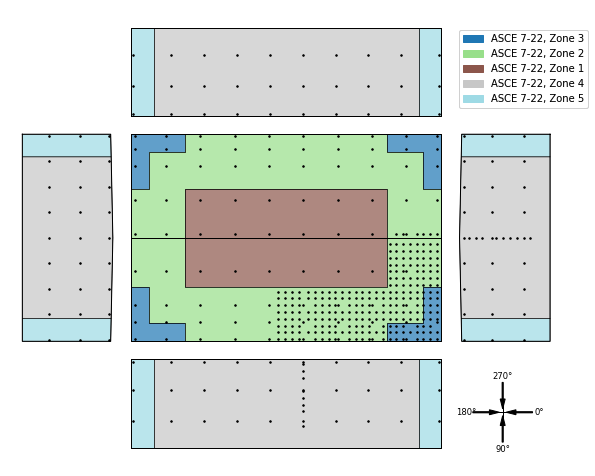

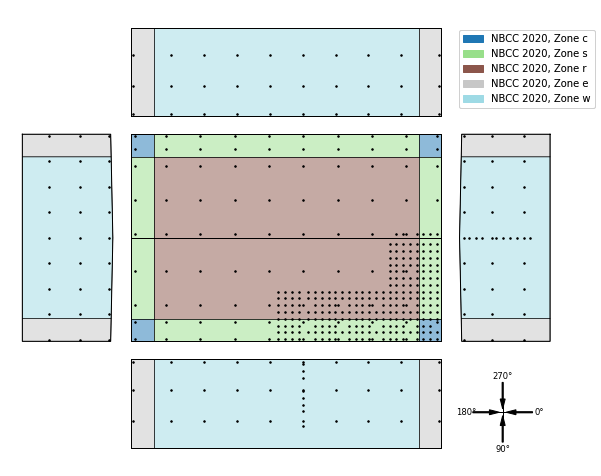

In [52]:

fig = plt.figure(figsize=[10,8.5])
ax = fig.add_subplot()
bldg_ASCE.plotEdges(ax=ax,showName=False)
bldg_ASCE.plotTaps(ax=ax,showTapNo=False)
# bldg_ASCE.plotTribs(ax=ax)
_, legend, _ = bldg_ASCE.plotZones(ax=ax)
ax.add_artist(legend)
legend.set_bbox_to_anchor((0.81, 0.95))
bldg_ASCE.plotAoA_definition(ax=ax, size=0.7, marginFactor=[1.0,0.5], location='lower right')
ax.axis('equal')
ax.axis('off')
plt.show()

# if saveFigs:
#     fig.savefig(figDir+"tapAndZoneLayout_ASCE.svg",format='svg',dpi=1200, bbox_inches='tight')
#     print("Figure saved to: "+figDir+"tapAndZoneLayout_ASCE.svg")


fig = plt.figure(figsize=[10,8.5])
ax = fig.add_subplot()
bldg_NBCC.plotEdges(ax=ax,showName=False)
bldg_NBCC.plotTaps(ax=ax,showTapNo=False)
# bldg_NBCC.plotTribs(ax=ax)
_, legend, _ = bldg_NBCC.plotZones(ax=ax, kwargs_Fill={'alpha':0.5}, kwargs_Edge={'color':'k', 'linewidth':0.5, 'linestyle':'-'})
ax.add_artist(legend)
legend.set_bbox_to_anchor((0.81, 0.95))
bldg_NBCC.plotAoA_definition(ax=ax, size=0.7, marginFactor=[1.0,0.5], location='lower right')
ax.axis('equal')
ax.axis('off')
plt.show()

# if saveFigs:
#     fig.savefig(figDir+"tapAndZoneLayout_NBCC.svg",format='svg',dpi=1200, bbox_inches='tight')
#     print("Figure saved to: "+figDir+"tapAndZoneLayout_NBCC.svg")


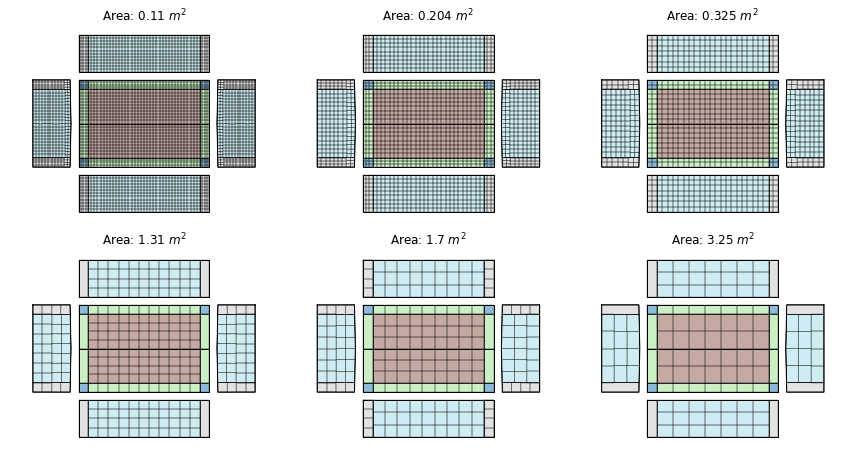

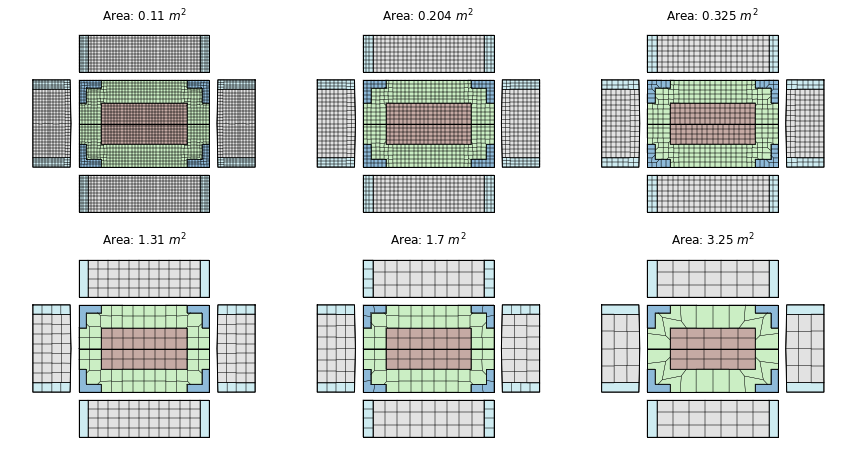

In [53]:
fig, axs = bldg_NBCC.plotPanels_AllAreas(figsize=[12,6.4], nCols=3,
    areaUnit=r'$m^2$', areaFactor=areaFactor_toFSm2, areaFmt='{:2.3g}',
    )
# if saveFigs:
#     fig.savefig(figDir+"nominalPanelAreas_NBCC.svg",format='svg',dpi=1200, bbox_inches='tight')

fig, axs = bldg_ASCE.plotPanels_AllAreas(figsize=[12,6.4], nCols=3,
    areaUnit=r'$m^2$', areaFactor=areaFactor_toFSm2, areaFmt='{:2.3g}',
    )
# if saveFigs:
#     fig.savefig(figDir+"nominalPanelAreas_ASCE.svg",format='svg',dpi=1200, bbox_inches='tight')

## Wind field

### Read data

In [54]:
keepTH = False

temp = h5py.File(dir_wtVl_tngE2+"tngE2Fr1_forPython.mat", 'r')
wtVel_E2 = wind.profile(name="BLWT-E2", Z=temp['Z'][0][()],UofT=temp['UofT'][()],VofT=temp['VofT'][()],WofT=temp['WofT'][()],H=H,dt=temp['dt'][0][0],nSpectAvg=64, keepTH=keepTH)

temp = h5py.File(dir_wtVl_tngE3+"tngE3Fr1_forPython.mat", 'r')
wtVel_E3 = wind.profile(name="BLWT-E3", Z=temp['Z'][0][()],UofT=temp['UofT'][()],VofT=temp['VofT'][()],WofT=temp['WofT'][()],H=H,dt=temp['dt'][0][0],nSpectAvg=64, keepTH=keepTH)


In [55]:
esdu74_E2 = wind.ESDU74(z0=0.01, Zref=H/lScl, Uref=25.0, Z=np.logspace(-1,2,100))
esdu74_E3 = wind.ESDU74(z0=0.087, Zref=H/lScl, Uref=25.0, Z=np.logspace(-1,2,100))
esdu85_E2 = wind.ESDU85(z0=0.01, Zref=H/lScl, Uref=25.0, Z=np.logspace(-1,2,100))
esdu85_E3 = wind.ESDU85(z0=0.087, Zref=H/lScl, Uref=25.0, Z=np.logspace(-1,2,100))
vel_es85 = wind.Profiles([wtVel_E2, esdu85_E2.toProfileObj(), wtVel_E3, esdu85_E3.toProfileObj(), ])
vel_es74 = wind.Profiles([wtVel_E2, esdu74_E2.toProfileObj(), wtVel_E3, esdu74_E3.toProfileObj(), ])

### Plot wind field

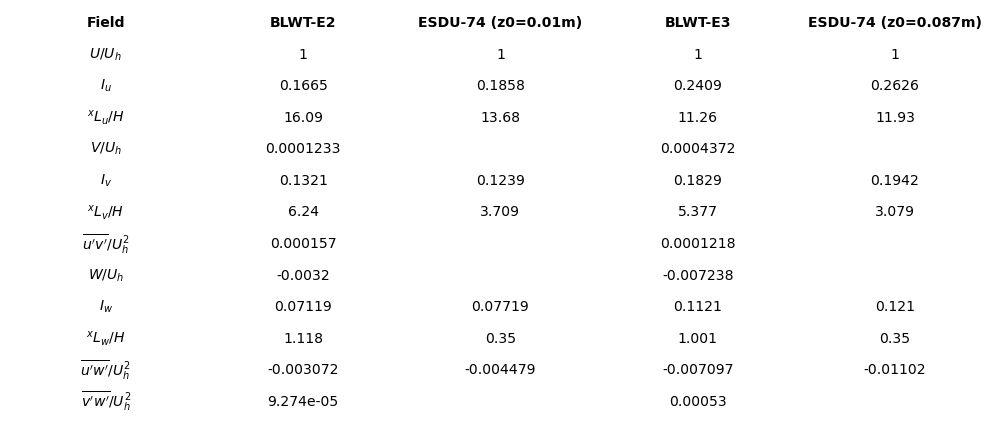

(<Figure size 1008x432 with 1 Axes>, <AxesSubplot:>)

In [56]:
vel_es74.plotRefHeightStatsTable(figsize=[12,6],fontSz=14)

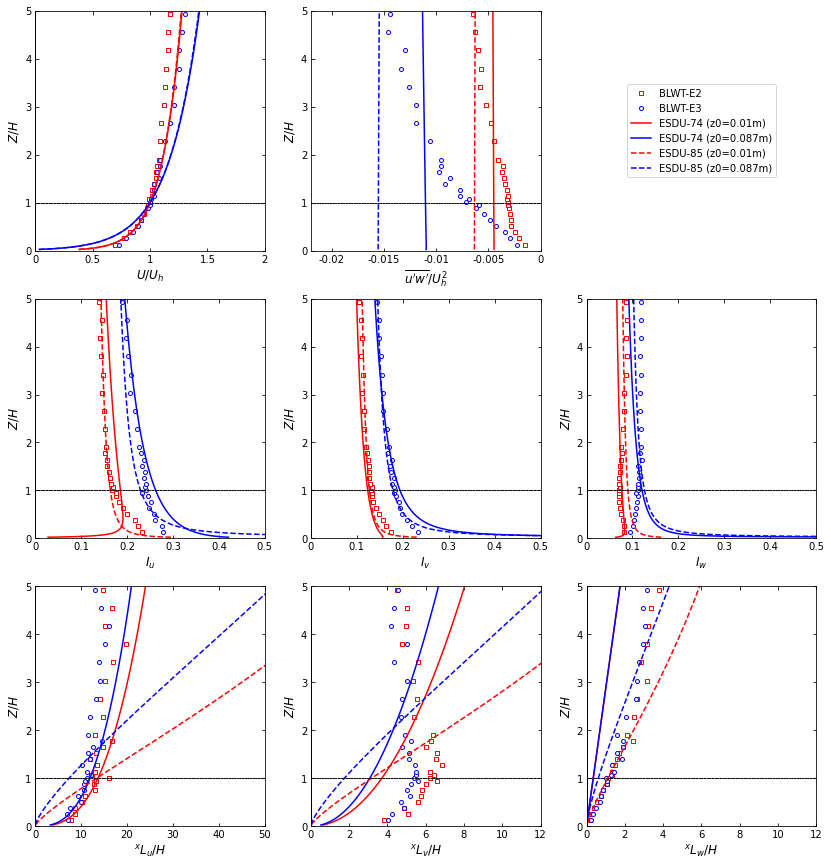

In [57]:
# profs = wind.Profiles([wtVel_E2, wtVel_E3, esdu85_E2.toProfileObj(), esdu85_E3.toProfileObj()])
profs = wind.Profiles([wtVel_E2, wtVel_E3, esdu74_E2.toProfileObj(), esdu74_E3.toProfileObj(), esdu85_E2.toProfileObj(), esdu85_E3.toProfileObj()])

fig, axs = profs.plotProfile_basic2(figsize=[14,15],
            yLimits=[0,5],
            xLimits_U=[0, 2], xLimits_uw=[-0.022, 0.0], 
            xLimits_Iu=[0,0.5], xLimits_Iv=[0,0.5], xLimits_Iw=[0,0.5], 
            xLimits_xLu=[0, 50], xLimits_xLv=[0,12], xLimits_xLw=[0,12], 
            kwargs_plt=[{'color': 'r', 'linewidth':0.5, 'linestyle': 'None',    'marker': 's', 'markersize':4, 'markerfacecolor':'w'},
                        {'color': 'b', 'linewidth':0.5, 'linestyle': 'None',    'marker': 'o', 'markersize':4, 'markerfacecolor':'w'},
                        {'color': 'r', 'linewidth':1.5, 'linestyle': '-',       'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
                        {'color': 'b', 'linewidth':1.5, 'linestyle': '-',       'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
                        {'color': 'r', 'linewidth':1.5, 'linestyle': '--',      'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
                        {'color': 'b', 'linewidth':1.5, 'linestyle': '--',      'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
                        ],
            lgnd_kwargs={'bbox_to_anchor': (0.5, 0.5), 'loc': 'center', 'ncol': 1},
            kwargs_ax={'gridMajor':False}
            )

#### $U$ and $I_u$ profiles and $S_{uu}$ spectra

#### $S_{uu}$, $S_{vv}$, and $S_{ww}$ spectra

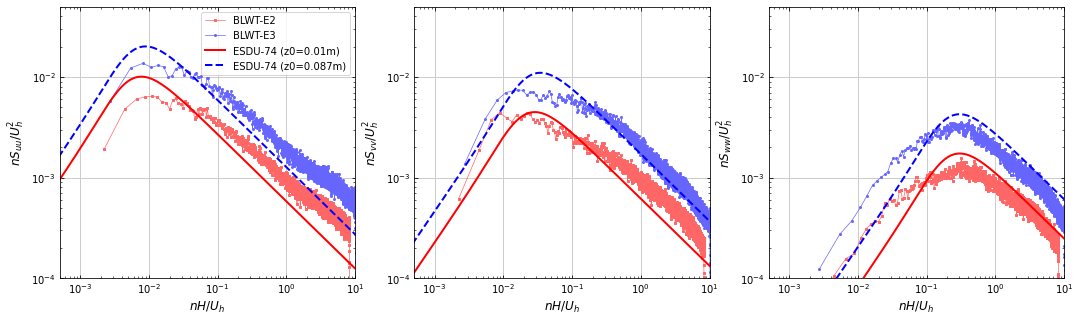

In [58]:
profs = wind.Profiles([wtVel_E2, wtVel_E3, esdu74_E2.toProfileObj(), esdu74_E3.toProfileObj(), ])

clb = 0.4
r = [1.0, clb, clb, 1.0]
b = [clb, clb, 1.0, 1.0]
kwargs_plt=[{'color': r, 'markerfacecolor':r, 'markeredgecolor':r, 'alpha':1, 'linewidth':0.7, 'linestyle': '-',    'marker': 's', 'markersize':2},
            {'color': b, 'markerfacecolor':b, 'markeredgecolor':b, 'alpha':1, 'linewidth':0.7, 'linestyle': '-',    'marker': 'o', 'markersize':2},
            {'color': 'r', 'linewidth':2, 'linestyle': '-',       'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
            {'color': 'b', 'linewidth':2, 'linestyle': '--',      'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
            {'color': 'r', 'linewidth':2, 'linestyle': '-.',      'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
            {'color': 'b', 'linewidth':2, 'linestyle': '-',       'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
            ]

fig = profs.plotSpect(figsize=[18,5], xLimits=[5e-4, 1e1], yLimits=[[1e-4,3e-2],[1e-4,3e-2],[1e-4,3e-2]],
                      xLabel=r'$nH/U_h$', yLabel_Suu=r'$nS_{uu}/U_h^2$', yLabel_Svv=r'$nS_{vv}/U_h^2$', yLabel_Sww=r'$nS_{ww}/U_h^2$',
                      kwargs_plt=kwargs_plt,)

## Surface pressure, $C_p$

### Read data

In [59]:
analogChannels_idxs={
                'main_pitot': 0,
                'xref_pitot': 2,
            }
pressureExtraChannels_tapNos={
                'main_pitot_zero': 3009,
                'main_pitot_q': 3010,
                '20inch_pitot_zero': 3007,
                '20inch_pitot_q': 3008,
                'Uh_pitot_zero': 3005,
                'Uh_pitot_q': 3006,
            }

peakSpecs = wind.DEFAULT_PEAK_SPECS
peakSpecs['Num_seg'] = 16
peakSpecs['Duration'] = 16
peakSpecs['prob_non_excd'] = 0.8

mainRefPitotChnlIdx = 2
Zpitot = 1.48
Ntaps = 456
lowpassFreq=200.0

#### Wind tunnel data

In [60]:
cps_OP = []
for i, rID in enumerate(runIDs):
    print(">> Processing: OP-"+rID)
    cp_raw = wt.BLWTL_HFPI(
        caseDir=dir_wtCp_tngE2[i],
        userNotes=None,
        Z_MainPitot=Zpitot,
        analogChannels_idxs=analogChannels_idxs,
        pressureExtraChannels_tapNos=pressureExtraChannels_tapNos,
        lowpassFreq=lowpassFreq,
        Ntaps=Ntaps,
    )
    winsound.Beep(1000, 1000)
    print("      Loaded raw data")
    print(cp_raw.description)

    cp = wind.bldgCp(
                    bldgName=bldg_ASCE.name,
                    faces=bldg_ASCE.faces,
                    H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                    AoA_zero_deg_basisVector=bldg_ASCE.AoA_zero_deg_basisVector,
                    AoA_rotation_direction=bldg_ASCE.AoA_rotation_direction,
                    caseName='OP_ASCE_C&C_'+rID,
                    refProfile=wtVel_E2,
                    Zref_input=cp_raw.Z_MainPitot,
                    Uref_input=cp_raw.Uref,
                    samplingFreq=cp_raw.sampleRate,
                    AoA=cp_raw.AoA,
                    CpOfT=cp_raw.CpTH,
                    notes_Cp=cp_raw.description,
                    badTaps=None,
                    reReferenceCpToH=True,
                    pOfT=None,
                    p0ofT=None,
                    CpStats=None,
                    peakSpecs=peakSpecs,
                    keepTH=False,
                    )
    winsound.Beep(1500, 1000)
    print("      << Complete!")
    cps_OP.append(cp)

# del cp_raw, cp

>> Processing: OP-p1
Reading HFPI data from: E:/TNG/rawHFPI/tngE2p1/
   Reading file: E:/TNG/rawHFPI/tngE2p1/TNGp1E02R001P001a.pssd
   Reading file: E:/TNG/rawHFPI/tngE2p1/TNGp1E02R001P002a.pssd
   Reading file: E:/TNG/rawHFPI/tngE2p1/TNGp1E02R001P003a.pssd
   Reading file: E:/TNG/rawHFPI/tngE2p1/TNGp1E02R001P004a.pssd
   Reading file: E:/TNG/rawHFPI/tngE2p1/TNGp1E02R001P005a.pssd
   Reading file: E:/TNG/rawHFPI/tngE2p1/TNGp1E02R001P006a.pssd
   Reading file: E:/TNG/rawHFPI/tngE2p1/TNGp1E02R001P007a.pssd
   Reading file: E:/TNG/rawHFPI/tngE2p1/TNGp1E02R001P008a.pssd
   Reading file: E:/TNG/rawHFPI/tngE2p1/TNGp1E02R001P009a.pssd
   Reading file: E:/TNG/rawHFPI/tngE2p1/TNGp1E02R001P010a.pssd
   Reading file: E:/TNG/rawHFPI/tngE2p1/TNGp1E02R001P011a.pssd
   Reading file: E:/TNG/rawHFPI/tngE2p1/TNGp1E02R001P012a.pssd
   Reading file: E:/TNG/rawHFPI/tngE2p1/TNGp1E02R001P013a.pssd
   Reading file: E:/TNG/rawHFPI/tngE2p1/TNGp1E02R001P014a.pssd
   Reading file: E:/TNG/rawHFPI/tngE2p1/TNGp1E02R

In [61]:
cps_SU = []
for i, rID in enumerate(runIDs):
    print(">> Processing: SU-"+rID)
    cp_raw = wt.BLWTL_HFPI(
                    caseDir=dir_wtCp_tngE3[i],
                    userNotes=None,
                    Z_MainPitot=Zpitot,
                    analogChannels_idxs=analogChannels_idxs,
                    pressureExtraChannels_tapNos=pressureExtraChannels_tapNos,
                    lowpassFreq=lowpassFreq,
                    Ntaps=Ntaps,
                    )
    winsound.Beep(1000, 1000)
    print("      Loaded raw data")
    print(cp_raw.description)

    cp = wind.bldgCp(
                    bldgName=bldg_ASCE.name,
                    faces=bldg_ASCE.faces,
                    H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                    AoA_zero_deg_basisVector=bldg_ASCE.AoA_zero_deg_basisVector,
                    AoA_rotation_direction=bldg_ASCE.AoA_rotation_direction,
                    caseName='SU_ASCE_C&C_'+rID,
                    refProfile=wtVel_E3,
                    Zref_input=cp_raw.Z_MainPitot,
                    Uref_input=cp_raw.Uref,
                    samplingFreq=cp_raw.sampleRate,
                    AoA=cp_raw.AoA,
                    CpOfT=cp_raw.CpTH,
                    notes_Cp=cp_raw.description,
                    badTaps=None,
                    reReferenceCpToH=True,
                    pOfT=None,
                    p0ofT=None,
                    CpStats=None,
                    peakSpecs=peakSpecs,
                    keepTH=False,
                    )
    winsound.Beep(1500, 1000)
    print("      << Complete!")
    cps_SU.append(cp)

# del cp_raw, cp

>> Processing: SU-p1
Reading HFPI data from: E:/TNG/rawHFPI/tngE3p1/
   Reading file: E:/TNG/rawHFPI/tngE3p1/TNGp1E03R001P001a.pssd
   Reading file: E:/TNG/rawHFPI/tngE3p1/TNGp1E03R001P002a.pssd
   Reading file: E:/TNG/rawHFPI/tngE3p1/TNGp1E03R001P003a.pssd
   Reading file: E:/TNG/rawHFPI/tngE3p1/TNGp1E03R001P004a.pssd
   Reading file: E:/TNG/rawHFPI/tngE3p1/TNGp1E03R001P005a.pssd
   Reading file: E:/TNG/rawHFPI/tngE3p1/TNGp1E03R001P006a.pssd
   Reading file: E:/TNG/rawHFPI/tngE3p1/TNGp1E03R001P007a.pssd
   Reading file: E:/TNG/rawHFPI/tngE3p1/TNGp1E03R001P008a.pssd
   Reading file: E:/TNG/rawHFPI/tngE3p1/TNGp1E03R001P009a.pssd
   Reading file: E:/TNG/rawHFPI/tngE3p1/TNGp1E03R001P010a.pssd
   Reading file: E:/TNG/rawHFPI/tngE3p1/TNGp1E03R001P011a.pssd
   Reading file: E:/TNG/rawHFPI/tngE3p1/TNGp1E03R001P012a.pssd
   Reading file: E:/TNG/rawHFPI/tngE3p1/TNGp1E03R001P013a.pssd
   Reading file: E:/TNG/rawHFPI/tngE3p1/TNGp1E03R001P014a.pssd
   Reading file: E:/TNG/rawHFPI/tngE3p1/TNGp1E03R

### $C_p$ Plots

In [ ]:
# cps_OP = cps_OP[:5]
cp_raw = wt.BLWTL_HFPI(
        caseDir=dir_wtCp_tngE2[i],
        userNotes=None,
        Z_MainPitot=Zpitot,
        analogChannels_idxs=analogChannels_idxs,
        pressureExtraChannels_tapNos=pressureExtraChannels_tapNos,
        lowpassFreq=lowpassFreq,
        Ntaps=Ntaps,
    )


In [ ]:
WTTDATALOG = cp_raw.all_WTTDATALOGs[0]
var = np.squeeze(WTTDATALOG["SampleRate"][0][0])
print(cp_raw.description)

HFPI data from BLWTL
Case directory: E:/TNG/rawHFPI/tngE2p5/
User notes: None
Main pitot Z: 1.48 m
Lowpass frequency: 200.0 Hz
Barocel range factor: {
    "main_pitot": 29.917,
    "xcheck_pitot": 29.917
}
Ntaps: 456
AoA: [45.] deg.
Sample rate (raw): [700.28011204] Hz
Sample rate (filtered): [200.] Hz
Test duration: 300.0 sec.
Floor exposure: 
		Bank	Block height (in)
		1	2.0
		2	2.0
		3	2.0
		4	2.0
		5	2.0
		6	2.0
		7	0.33
		8	0.33
		9	0.33
		10	0.33
		11	0.0
Analog channels indecies: {
    "main_pitot": 0,
    "xref_pitot": 2
}
Pressure extra channels tap Nos.: {
    "main_pitot_zero": 3009,
    "main_pitot_queue": 3010,
    "20inch_pitot_zero": 3007,
    "20inch_pitot_queue": 3008,
    "Uh_pitot_zero": 3005,
    "Uh_pitot_queue": 3006
}



In [ ]:
for exp, cases in zip(['OP','SU'],[cps_OP, cps_SU]):
    N = len(cases)

    fig, axs = plt.subplots(N+1,4,figsize=[18,N*5])
    ax_cbar1 = axs[N,0]
    ax_cbar2 = axs[N,1]
    ax_cbar3 = axs[N,2]
    ax_cbar4 = axs[N,3]
    fig.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)

    # kwargs_contourTxt={'inline':True, 'fmt':'%.2g','fontsize':4, 'colors':'b', } #'inline_spacing':10,}
    # kwargs_contourEdge={'colors':'k', 'linewidths':0.3, 'linestyles':'-', 'alpha':1.0,}

    for i, cp in enumerate(cases):
        fld, fldrange, ticks = 'mean', [-2.5, 1.1], np.linspace(-2.5,1.0,8)
        ax = axs[i,0]
        im = cp.plotTapCpStatContour(ax=ax, envelopeType='low',fieldName=fld,fldRange=fldrange,nLvl=30,title=fld+r" $C_p$",
                                    showValuesOnContour=True, showContourEdge=True, )
        cp.plotEdges(ax=ax, showName=False, kwargs_Edge={'color':'k', 'linewidth':1.5, 'linestyle':'-'})
        cp.plotTaps(ax=ax, showTapNo=False, kwargs_dots={'color':[0.5,0.5,0.5,0.5], 'marker':'.', 'markersize':0.5, 'linestyle':'None', })
        ax.axis('equal')
        ax.axis('off')
        ax.text(-0.01, 0.5, cp.name, va='center', ha='center', rotation='vertical', fontsize=14, transform=ax.transAxes)
        if i == N-1:
            ax_cbar1.axis('on')
            cbar = fig.colorbar(im[0], cax=ax_cbar1, orientation='horizontal',aspect=20,shrink=0.5,pad=0.08)
            cbar.set_ticks(ticks)
            cbar.ax.set_xlabel("Enveloped "+fld+r" $C_p$", fontsize=14, rotation=0, labelpad=10)
            cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}'))
            cbar.ax.xaxis.set_label_position('top')
            pos = ax_cbar1.get_position()
            new_pos = [pos.x0+pos.width*0.1, pos.y0+pos.height*0.9, pos.width*0.8, pos.height*0.06]
            ax_cbar1.set_position(new_pos)


        fld, fldrange, ticks = 'std', [0, 1.], np.linspace(0.0,1.0,10)
        ax = axs[i,1]
        im = cp.plotTapCpStatContour(ax=ax, envelopeType='high',fieldName=fld,fldRange=fldrange,nLvl=30,title=fld+r" $C_p$", 
                                    showValuesOnContour=True, showContourEdge=True, )
        cp.plotEdges(ax=ax, showName=False, kwargs_Edge={'color':'k', 'linewidth':1.5, 'linestyle':'-'})
        cp.plotTaps(ax=ax, showTapNo=False, kwargs_dots={'color':[0.5,0.5,0.5,0.5], 'marker':'.', 'markersize':0.5, 'linestyle':'None', })
        ax.axis('equal')
        ax.axis('off')
        if i == N-1:
            ax_cbar2.axis('on')
            cbar = fig.colorbar(im[0], cax=ax_cbar2, orientation='horizontal',aspect=20,shrink=0.7,pad=0.08)
            cbar.set_ticks(ticks)
            cbar.ax.set_xlabel("Enveloped "+fld+r" $C_p$", fontsize=14, rotation=0, labelpad=10)
            cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}'))
            cbar.ax.xaxis.set_label_position('top')
            pos = ax_cbar2.get_position()
            new_pos = [pos.x0+pos.width*0.1, pos.y0+pos.height*0.9, pos.width*0.8, pos.height*0.06]
            ax_cbar2.set_position(new_pos)


        fld, fldrange, ticks = 'peakMin', [-12.0, 1.], np.linspace(-12.0,1.0,10)
        ax = axs[i,2]
        im = cp.plotTapCpStatContour(ax=ax, envelopeType='low',fieldName=fld,fldRange=fldrange,nLvl=30,title=fld+r" $C_p$", 
                                    showValuesOnContour=True, showContourEdge=True, )
        cp.plotEdges(ax=ax, showName=False, kwargs_Edge={'color':'k', 'linewidth':1.5, 'linestyle':'-'})
        cp.plotTaps(ax=ax, showTapNo=False, kwargs_dots={'color':[0.5,0.5,0.5,0.5], 'marker':'.', 'markersize':0.5, 'linestyle':'None', })
        ax.axis('equal')
        ax.axis('off')
        if i == N-1:
            ax_cbar3.axis('on')
            cbar = fig.colorbar(im[0], cax=ax_cbar3, orientation='horizontal',aspect=20,shrink=0.7,pad=0.08)
            cbar.set_ticks(ticks)
            cbar.ax.set_xlabel("Enveloped "+fld+r" $C_p$", fontsize=14, rotation=0, labelpad=10)
            cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}'))
            cbar.ax.xaxis.set_label_position('top')
            pos = ax_cbar3.get_position()
            new_pos = [pos.x0+pos.width*0.1, pos.y0+pos.height*0.9, pos.width*0.8, pos.height*0.06]
            ax_cbar3.set_position(new_pos)


        fld, fldrange, ticks = 'peakMax', [-2.0, 5.0], np.linspace(-2.0,5.0,10)
        ax = axs[i,3]
        im = cp.plotTapCpStatContour(ax=ax, envelopeType='high',fieldName=fld,fldRange=fldrange,nLvl=30,title=fld+r" $C_p$",
                                        showValuesOnContour=True, showContourEdge=True, )
        cp.plotEdges(ax=ax, showName=False, kwargs_Edge={'color':'k', 'linewidth':1.5, 'linestyle':'-'})
        cp.plotTaps(ax=ax, showTapNo=False, kwargs_dots={'color':[0.5,0.5,0.5,0.5], 'marker':'.', 'markersize':0.5, 'linestyle':'None', })
        ax.axis('equal')
        ax.axis('off')
        if i == N-1:
            ax_cbar4.axis('on')
            cbar = fig.colorbar(im[0], cax=ax_cbar4, orientation='horizontal',aspect=20,shrink=0.7,pad=0.08)
            cbar.set_ticks(ticks)
            cbar.ax.set_xlabel("Enveloped "+fld+r" $C_p$", fontsize=14, rotation=0, labelpad=10)
            cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}'))
            cbar.ax.xaxis.set_label_position('top')
            pos = ax_cbar4.get_position()
            new_pos = [pos.x0+pos.width*0.1, pos.y0+pos.height*0.9, pos.width*0.8, pos.height*0.06]
            ax_cbar4.set_position(new_pos)

    # if saveFigs:
    #     fileName = "CpContour_"+exp+".svg"
    #     fig.savefig(figDir+fileName+f".svg",format='svg',dpi=1200, bbox_inches='tight')
    #     print("Figure saved to: "+figDir+fileName+f".svg")

#### Local pressure

Number of member bldgs: 5


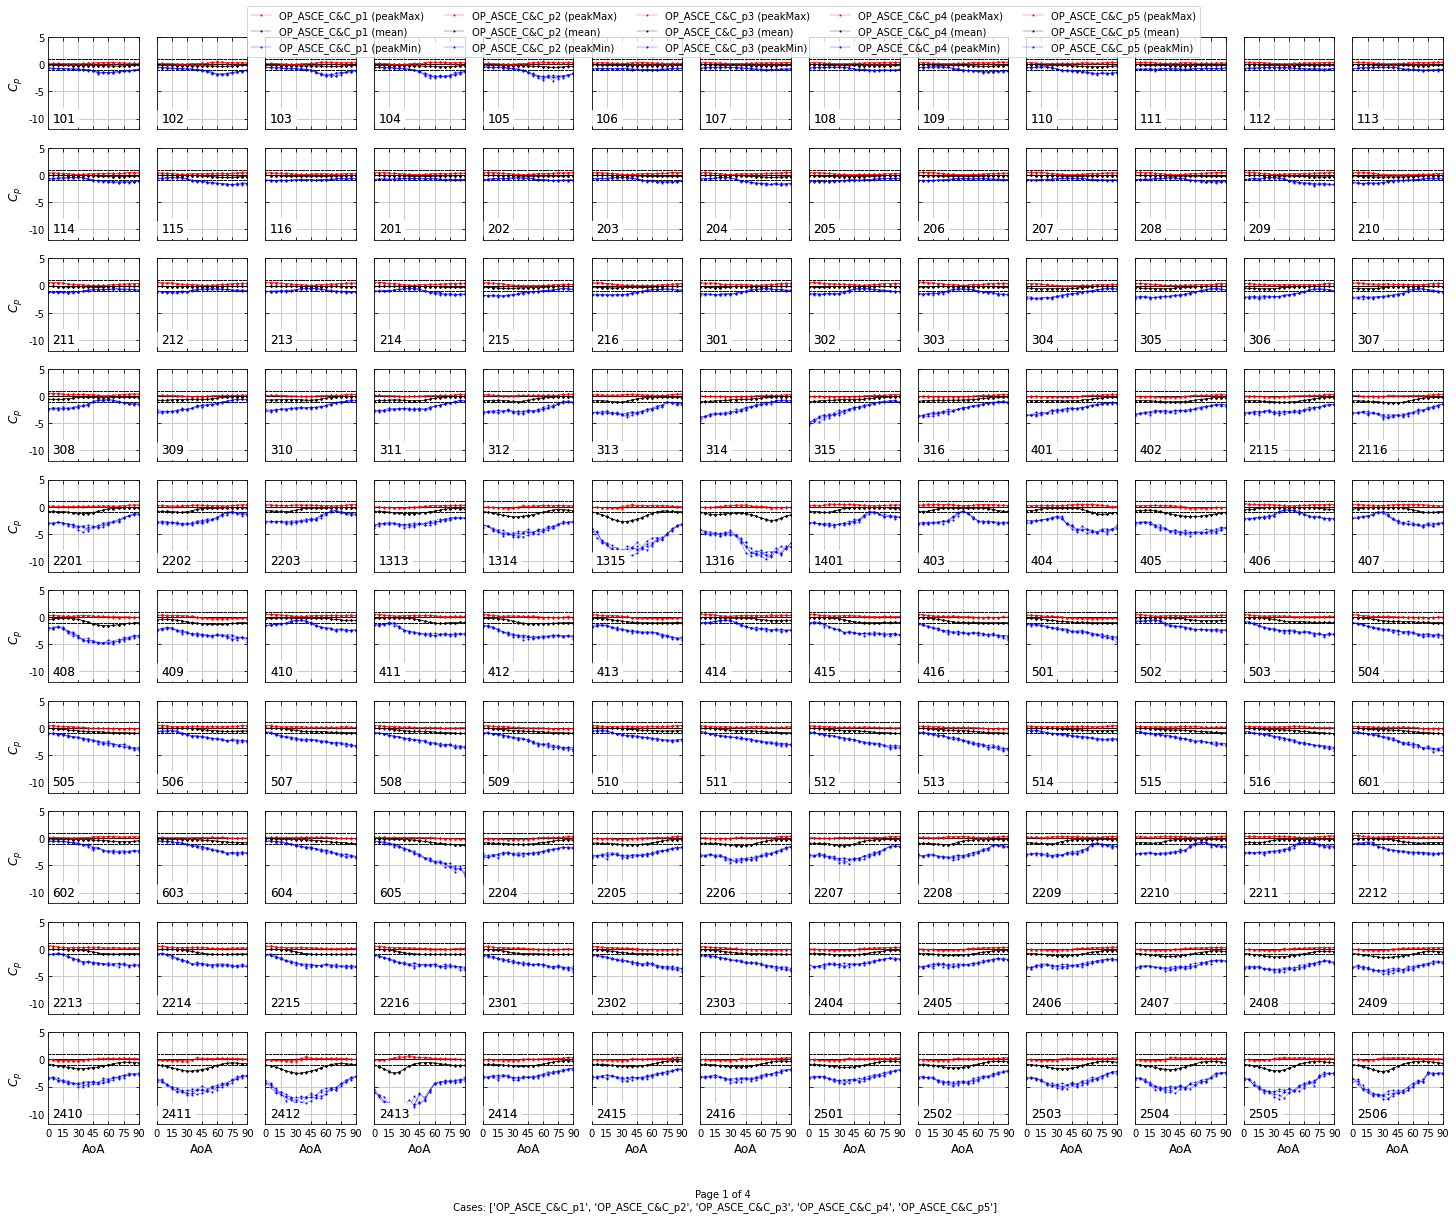

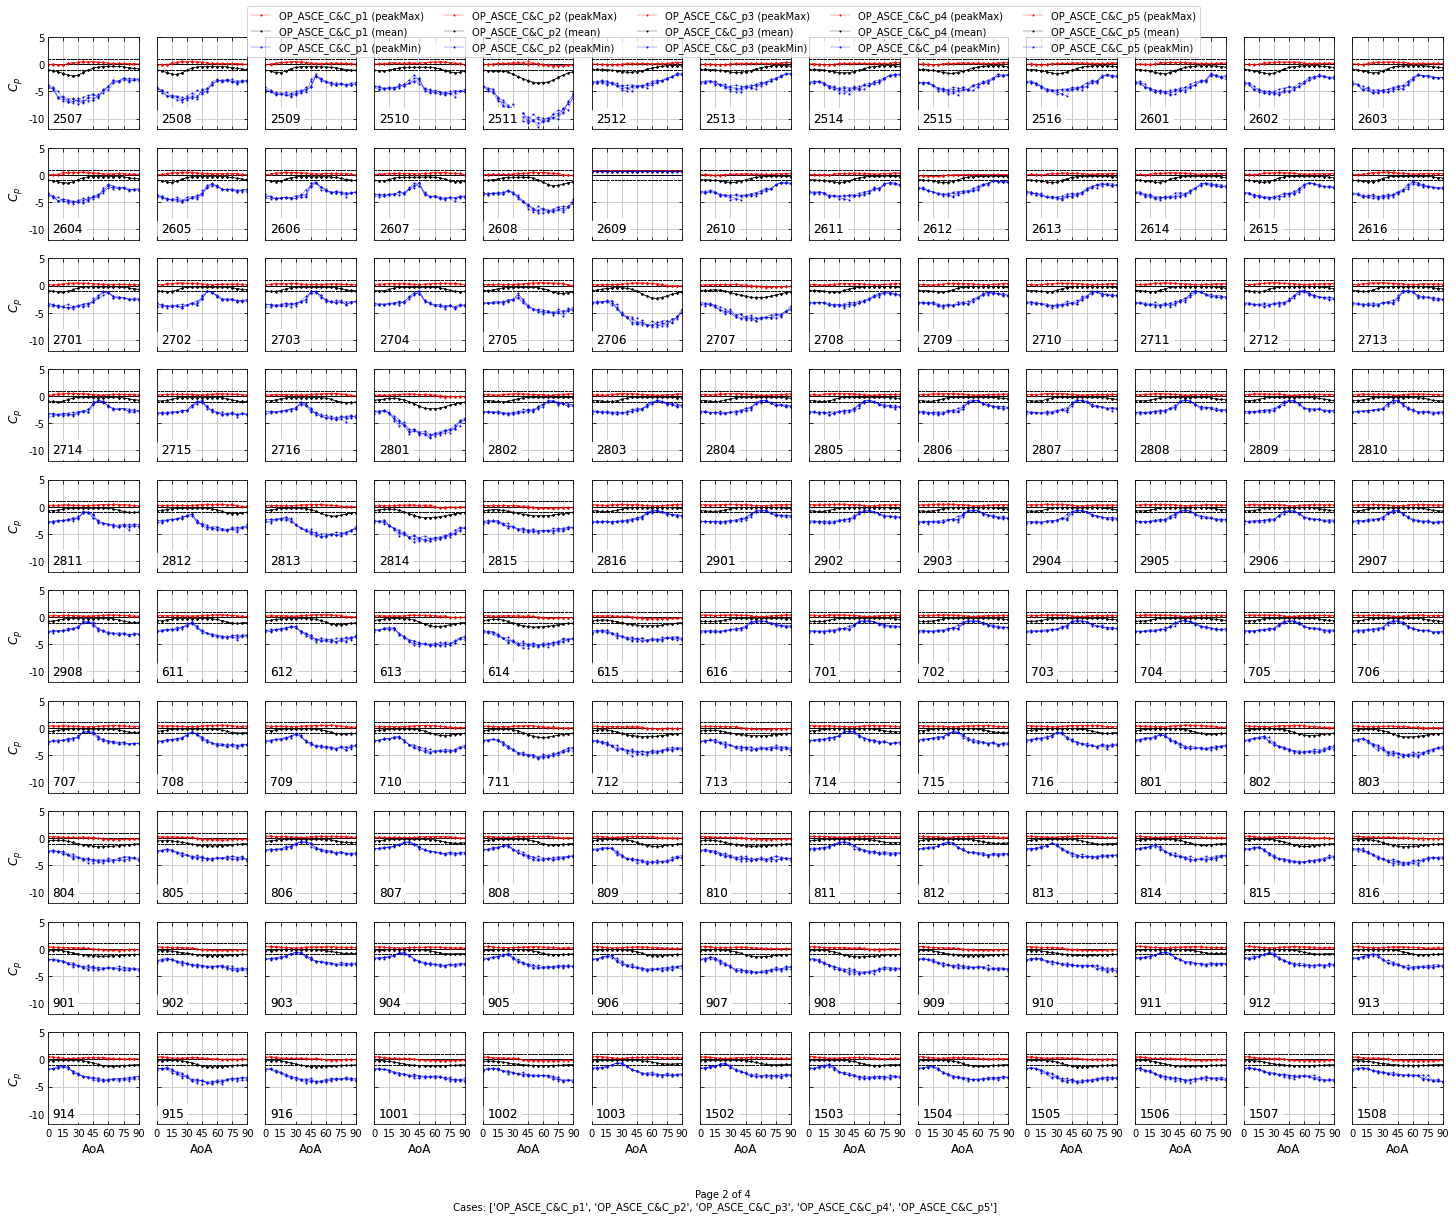

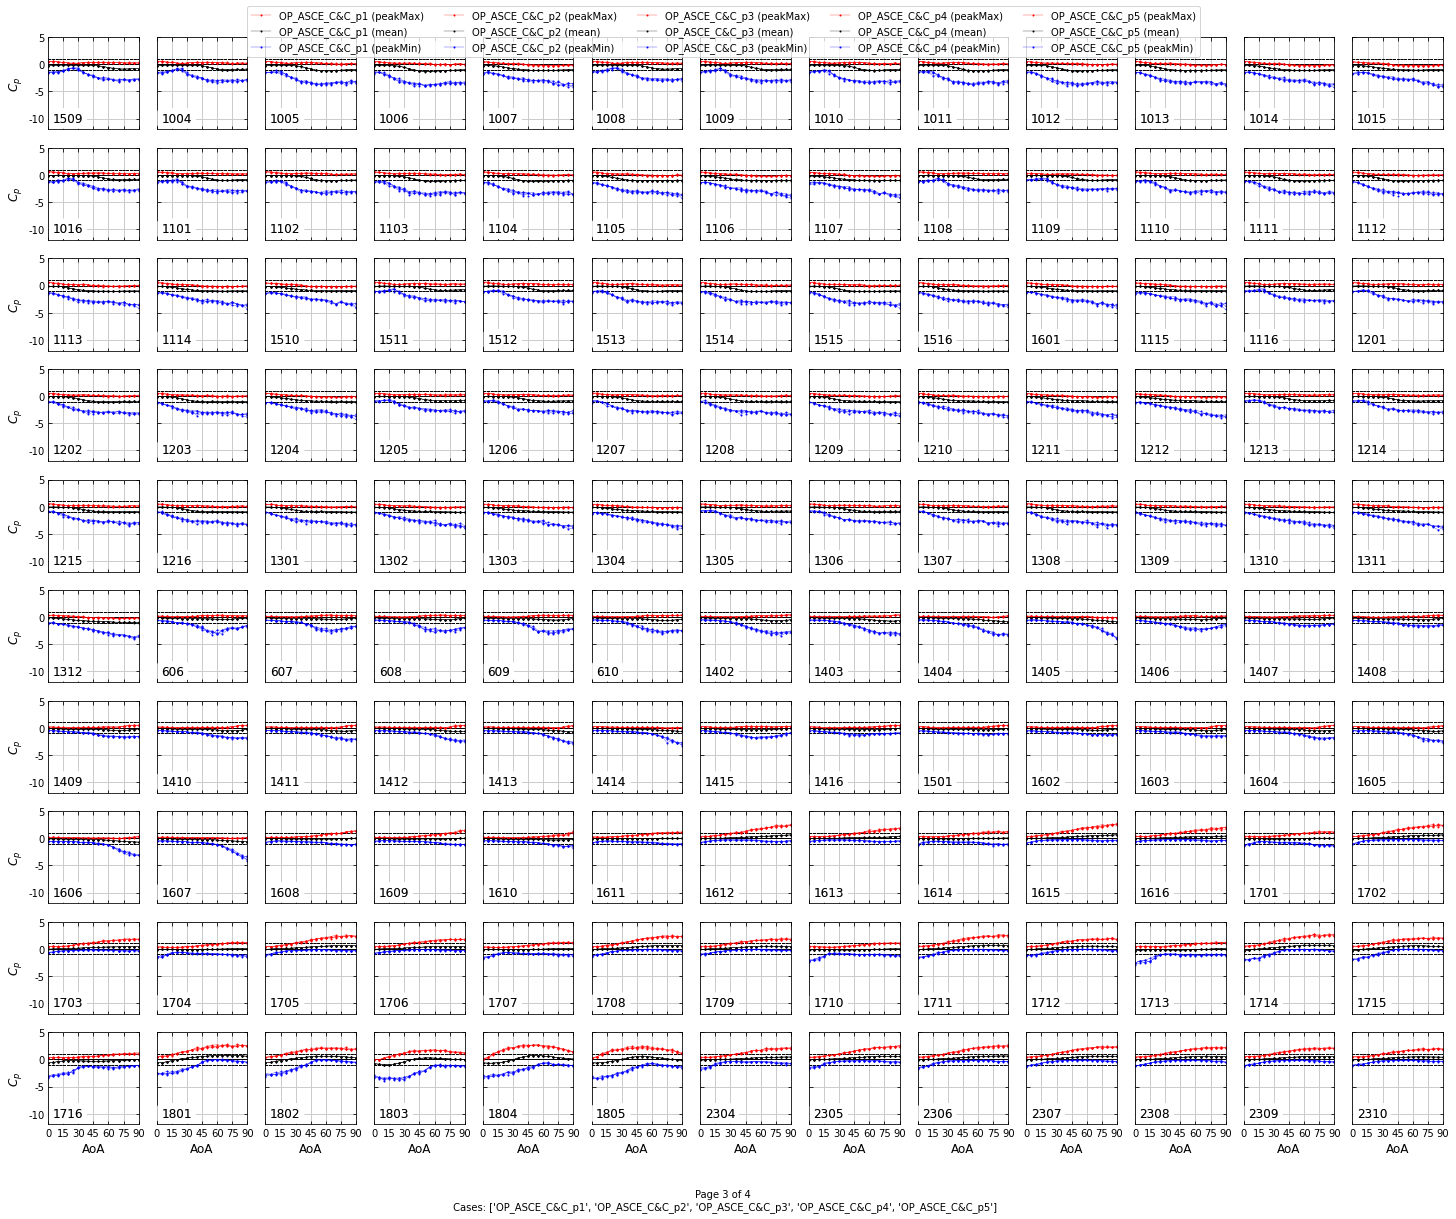

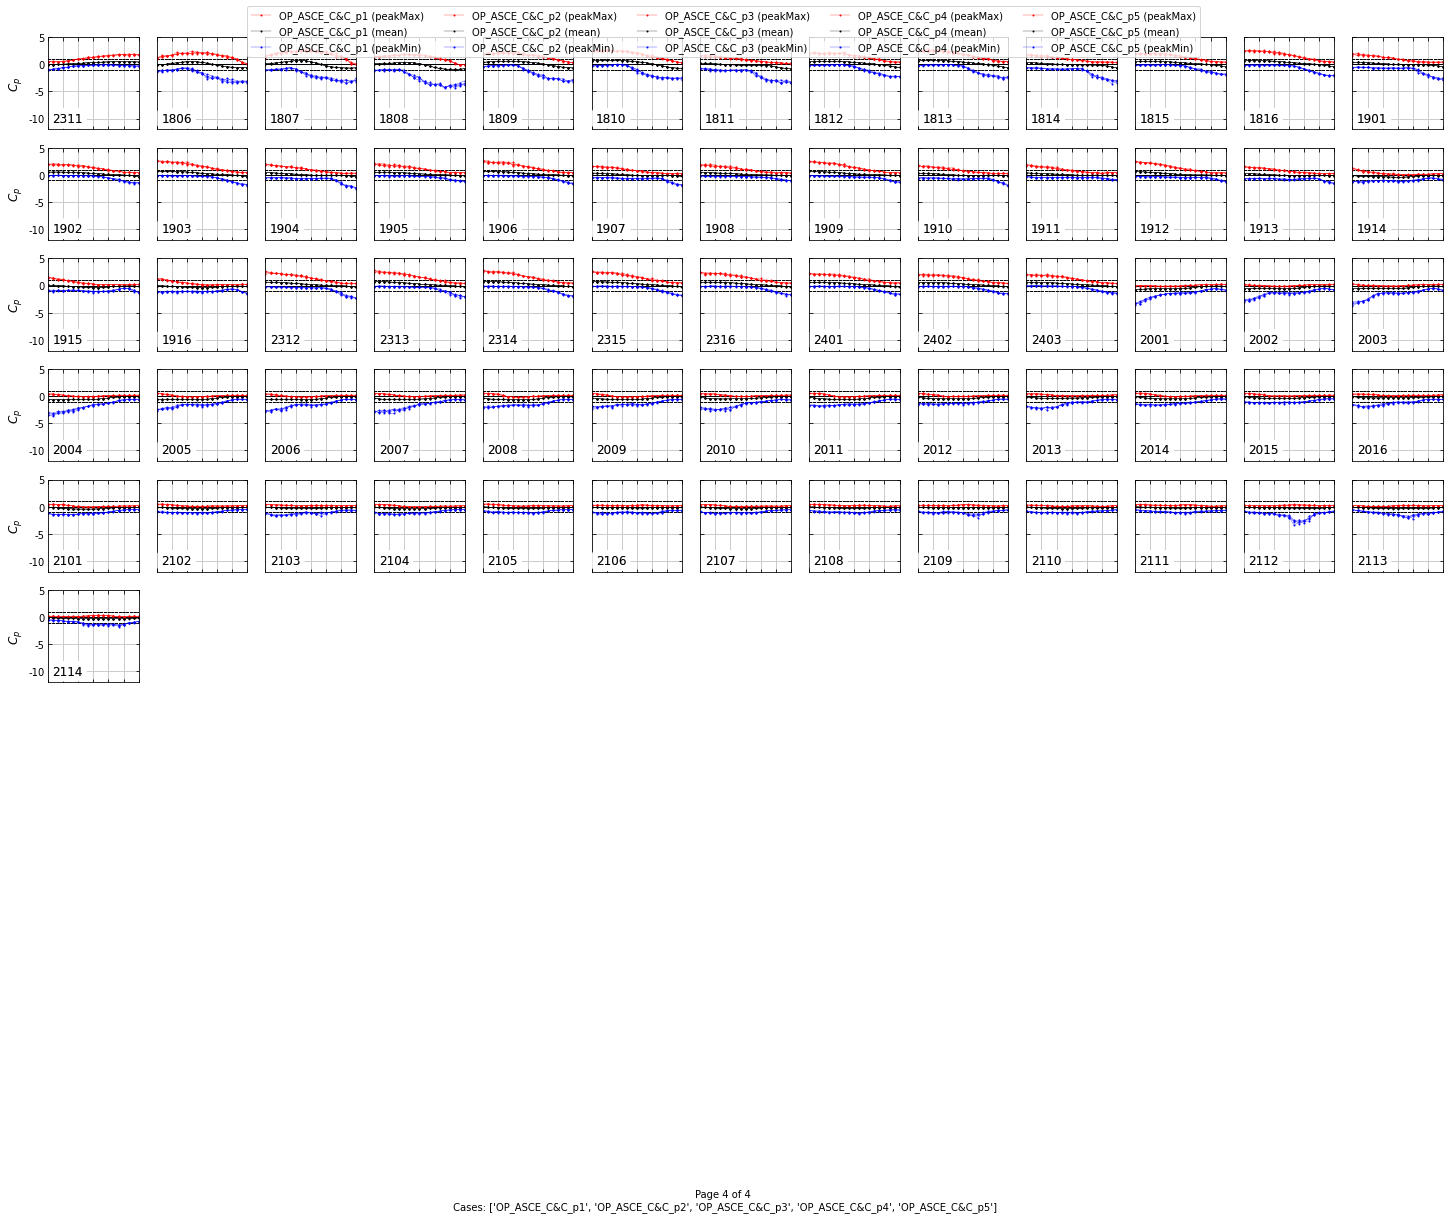

In [74]:
cps = wind.BldgCps(cps_OP)

cols = ['r','k','b','g','m','r','k','b','g','m']
# mrkrs = ['^','o','v','s','p','d','.','*','<','>','h']
mrkrs = ['.','.','.','.','.','.','.','','','','']
ls=['-','-','-','-','-','-','-','-','-','-',]
kwargs_perFld = [[{ 'color':cols[i], 
                    'marker':mrkrs[i], 
                    'ls':ls[i],
                    'markersize':2,
                    'linewidth':0.3,
                    } for i in range(3)]
                    for c in range(cps.Num_MemberBldgs)] 

_,_ = cps.plotTapCpStatsPerAoA(fldRange=[-12,5.0],pageNo_xy=(0.5,0.08),nCols=13, figsize=[25,20], xticks=np.arange(0,105,15),
                               kwargs_perFld=kwargs_perFld)


Number of member bldgs: 4
48


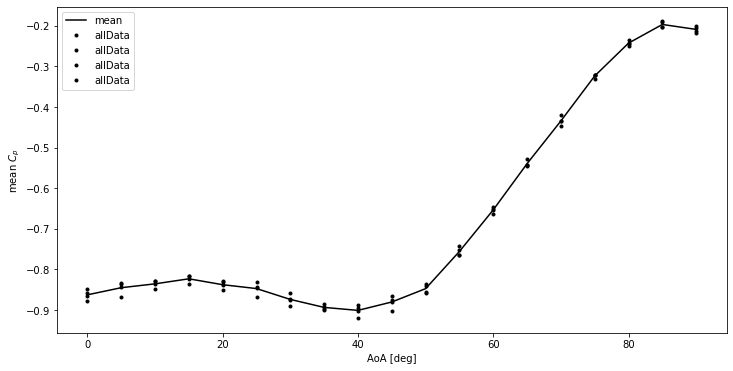

In [ ]:
bldgs = wind.BldgCps(cps_OP[:-1])

# print(bldgs.CpStats_avg.keys())
mean, upper, lower, allData = bldgs.CpStats()

fld = 'mean'
tapIdx = bldg_ASCE.tapIdxOf(401)
print(tapIdx)

fig = plt.figure(figsize=[12,6])
ax = fig.add_subplot()
ax.plot(bldgs.master.AoA, mean[fld][:,tapIdx], 'k-', label='mean')
# ax.plot(bldgs.master.AoA, upper[fld][:,tapIdx], 'r-', label='upper')
# ax.plot(bldgs.master.AoA, lower[fld][:,tapIdx], 'b-', label='lower')
# have the label for 'allData' only once but plot it for all records
ax.plot(bldgs.master.AoA, allData[fld][:,tapIdx], '.k', label='allData')
ax.set_xlabel('AoA [deg]')
ax.set_ylabel(fld+r' $C_p$')
ax.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some sample data
x = np.linspace(0, 10, 10)
y = np.sin(x)
y_err = np.random.rand(len(x))  # Random error values

# Plot the data with error bars
plt.figure(figsize=(15, 6))
plt.errorbar(x, y, yerr=y_err, fmt='o', capsize=10, capthick=0.5, ecolor='k', markerfacecolor='red', markeredgecolor='k', markeredgewidth=1,
             label='Data', zorder=1, alpha=0.9, markersize=10, linewidth=1.5, color='k', linestyle='--',)

# Add labels and title to the plot
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Data with Error Bars')

# Show the plot
plt.show()


In [ ]:
badTaps = np.array([1316, 1807, 2609,],dtype=int)
badIdx = np.where(np.in1d(bldg.tapNo, badTaps))[0]
mask = np.ones_like(bldg.tapNo, dtype=bool)
mask[badIdx] = False

fld = 'mean'
err_E2_mean = np.array([0,0,0],dtype=float)
for d in range(3):
    LES = lesCp_E2.CpStats[fld][d,mask]
    WT = wtCp_tngE2.CpStats[fld][d,mask]
    err_E2_mean[d] = np.mean(np.abs(LES-WT))/np.ptp(WT)

fld = 'std'
err_E2_std = np.array([0,0,0],dtype=float)
for d in range(3):
    LES = lesCp_E2.CpStats[fld][d,mask]
    WT = wtCp_tngE2.CpStats[fld][d,mask]
    err_E2_std[d] = np.mean(np.abs(LES-WT))/np.ptp(WT)

err_E2_peak = np.array([0,0,0],dtype=float)
for d in range(3):
    LES = np.append(lesCp_E2.CpStats['peakMax'][d,mask], lesCp_E2.CpStats['peakMin'][d,mask])
    WT = np.append(wtCp_tngE2.CpStats['peakMax'][d,mask], wtCp_tngE2.CpStats['peakMin'][d,mask])
    err_E2_peak[d] = np.mean(np.abs(LES-WT))/np.ptp(WT)


fld = 'mean'
err_E3_mean = np.array([0,0,0],dtype=float)
for d in range(3):
    LES = lesCp_E3.CpStats[fld][d,mask]
    WT = wtCp_tngE3.CpStats[fld][d,mask]
    err_E3_mean[d] = np.mean(np.abs(LES-WT))/np.ptp(WT)

fld = 'std'
err_E3_std = np.array([0,0,0],dtype=float)
for d in range(3):
    LES = lesCp_E3.CpStats[fld][d,mask]
    WT = wtCp_tngE3.CpStats[fld][d,mask]
    err_E3_std[d] = np.mean(np.abs(LES-WT))/np.ptp(WT)

err_E3_peak = np.array([0,0,0],dtype=float)
for d in range(3):
    LES = np.append(lesCp_E3.CpStats['peakMax'][d,mask], lesCp_E3.CpStats['peakMin'][d,mask])
    WT = np.append(wtCp_tngE3.CpStats['peakMax'][d,mask], wtCp_tngE3.CpStats['peakMin'][d,mask])
    err_E3_peak[d] = np.mean(np.abs(LES-WT))/np.ptp(WT)

err_E2_mean = np.transpose(err_E2_mean)*100
err_E2_std = np.transpose(err_E2_std)*100
err_E2_peak = np.transpose(err_E2_peak)*100
err_E3_mean = np.transpose(err_E3_mean)*100
err_E3_std = np.transpose(err_E3_std)*100
err_E3_peak = np.transpose(err_E3_peak)*100
print(err_E2_mean)
print(err_E2_std)
print(err_E2_peak)
print(err_E3_mean)
print(err_E3_std)
print(err_E3_peak)


In [ ]:
def forall(ax,lims):
    ax.tick_params(axis='both',direction='in',which='both',top=True,right=True)
    ax.plot([-100,100],[-100,100],'-k',lw=0.7)
    # ax.axis('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    # ax.set_xlabel('BLWT')
    # ax.set_ylabel('LES')
    


meanRng = [-4,1.5]
stdRng = [0,1.3]
peakRng = [-10,4.5]

fig = plt.figure(figsize=[13,6])
nrow,ncol = 2,4

ax = fig.add_subplot(nrow,ncol,1)
fld = 'mean'
ax.plot(wtCp_tngE2.CpStats[fld][0,mask], lesCp_E2.CpStats[fld][0,mask], '.r', label=r'$0^\circ$')
ax.plot(wtCp_tngE2.CpStats[fld][1,mask], lesCp_E2.CpStats[fld][1,mask], '.g', label=r'$45^\circ$')
ax.plot(wtCp_tngE2.CpStats[fld][2,mask], lesCp_E2.CpStats[fld][2,mask], '.b', label=r'$90^\circ$')
forall(ax,meanRng)
ax.legend()
ax.set_ylabel('LES')
ax.set_title(r'Mean $C_p$')

ax = fig.add_subplot(nrow,ncol,2)
fld = 'std'
ax.plot(wtCp_tngE2.CpStats[fld][0,mask], lesCp_E2.CpStats[fld][0,mask], '.r', label=r'$0^\circ$')
ax.plot(wtCp_tngE2.CpStats[fld][1,mask], lesCp_E2.CpStats[fld][1,mask], '.g', label=r'$45^\circ$')
ax.plot(wtCp_tngE2.CpStats[fld][2,mask], lesCp_E2.CpStats[fld][2,mask], '.b', label=r'$90^\circ$')
forall(ax,stdRng)
ax.set_title(r'Std. $C_p$')

ax = fig.add_subplot(nrow,ncol,3)
fld = 'peakMin'
ax.plot(wtCp_tngE2.CpStats[fld][0,mask], lesCp_E2.CpStats[fld][0,mask], '.r', label=r'E2-$0^\circ$')
ax.plot(wtCp_tngE2.CpStats[fld][1,mask], lesCp_E2.CpStats[fld][1,mask], '.g', label=r'E2-$45^\circ$')
ax.plot(wtCp_tngE2.CpStats[fld][2,mask], lesCp_E2.CpStats[fld][2,mask], '.b', label=r'E2-$90^\circ$')
fld = 'peakMax'
ax.plot(wtCp_tngE2.CpStats[fld][0,mask], lesCp_E2.CpStats[fld][0,mask], '.r', label=r'E2-$0^\circ$')
ax.plot(wtCp_tngE2.CpStats[fld][1,mask], lesCp_E2.CpStats[fld][1,mask], '.g', label=r'E2-$45^\circ$')
ax.plot(wtCp_tngE2.CpStats[fld][2,mask], lesCp_E2.CpStats[fld][2,mask], '.b', label=r'E2-$90^\circ$')
forall(ax,peakRng)
ax.set_title(r'Peak $C_p$')



ax = fig.add_subplot(nrow,ncol,4)
errNames = np.array([1.0, 2.0, 3.0],dtype=float)
ax.bar(errNames-0.2, err_E2_mean, width=0.2, color='r', label=r'$0^\circ$') #, hatch="/", hatch_scale=0.5)
ax.bar(errNames, err_E2_std, width=0.2, color='g', label=r'$45^\circ$') #, hatch="\\", hatch_scale=0.5)
ax.bar(errNames+0.2, err_E2_peak, width=0.2, color='b', label=r'$90^\circ$') #, hatch="+", hatch_scale=0.5)
ax.tick_params(axis='y',direction='in',which='both',right=True)
ax.legend()
ax.set_ylim([0, 13.0])
ax.set_title('NMAE [%]')
ax.set_xticklabels([' ', r'Mean $C_p$', r'Std. $C_p$', r'Peak $C_p$'])




ax = fig.add_subplot(nrow,ncol,5)
fld = 'mean'
ax.plot(wtCp_tngE3.CpStats[fld][0,mask], lesCp_E3.CpStats[fld][0,mask], '.r', label=r'E2-$0^\circ$')
ax.plot(wtCp_tngE3.CpStats[fld][1,mask], lesCp_E3.CpStats[fld][1,mask], '.g', label=r'E2-$45^\circ$')
ax.plot(wtCp_tngE3.CpStats[fld][2,mask], lesCp_E3.CpStats[fld][2,mask], '.b', label=r'E2-$90^\circ$')
forall(ax,meanRng)
ax.set_xlabel('BLWT')
ax.set_ylabel('LES')

ax = fig.add_subplot(nrow,ncol,6)
fld = 'std'
ax.plot(wtCp_tngE3.CpStats[fld][0,mask], lesCp_E3.CpStats[fld][0,mask], '.r', label=r'E2-$0^\circ$')
ax.plot(wtCp_tngE3.CpStats[fld][1,mask], lesCp_E3.CpStats[fld][1,mask], '.g', label=r'E2-$45^\circ$')
ax.plot(wtCp_tngE3.CpStats[fld][2,mask], lesCp_E3.CpStats[fld][2,mask], '.b', label=r'E2-$90^\circ$')
forall(ax,stdRng)
ax.set_xlabel('BLWT')

ax = fig.add_subplot(nrow,ncol,7)
fld = 'peakMin'
ax.plot(wtCp_tngE3.CpStats[fld][0,mask], lesCp_E3.CpStats[fld][0,mask], '.r', label=r'E2-$0^\circ$')
ax.plot(wtCp_tngE3.CpStats[fld][1,mask], lesCp_E3.CpStats[fld][1,mask], '.g', label=r'E2-$45^\circ$')
ax.plot(wtCp_tngE3.CpStats[fld][2,mask], lesCp_E3.CpStats[fld][2,mask], '.b', label=r'E2-$90^\circ$')
fld = 'peakMax'
ax.plot(wtCp_tngE3.CpStats[fld][0,mask], lesCp_E3.CpStats[fld][0,mask], '.r', label=r'E2-$0^\circ$')
ax.plot(wtCp_tngE3.CpStats[fld][1,mask], lesCp_E3.CpStats[fld][1,mask], '.g', label=r'E2-$45^\circ$')
ax.plot(wtCp_tngE3.CpStats[fld][2,mask], lesCp_E3.CpStats[fld][2,mask], '.b', label=r'E2-$90^\circ$')
forall(ax,peakRng)
ax.set_xlabel('BLWT')


ax = fig.add_subplot(nrow,ncol,8)
errNames = np.array([1.0, 2.0, 3.0],dtype=float)
ax.bar(errNames-0.2, err_E3_mean, width=0.2, color='r', label=r'$0^\circ$') #, hatch="/", hatch_scale=0.5)
ax.bar(errNames, err_E3_std, width=0.2, color='g', label=r'$45^\circ$') #, hatch="\\", hatch_scale=0.5)
ax.bar(errNames+0.2, err_E3_peak, width=0.2, color='b', label=r'$90^\circ$') #, hatch="+", hatch_scale=0.5)
ax.text(2.0, 11.0, r'$NMAE = \frac{\left| C_p^{LES} - C_p^{WT} \right|}{C_{p,max}^{WT} - C_{p,min}^{WT}}\times 100\%$',
        ha='center',fontsize=11)
ax.tick_params(axis='y',direction='in',which='both',right=True)
ax.set_ylim([0, 13.0])
ax.set_xticklabels([' ', r'Mean $C_p$', r'Std. $C_p$', r'Peak $C_p$'])


if saveFigs:
    fig.savefig(figDir+"Cp_WTvsLES.svg",format='svg',dpi=1200, bbox_inches='tight')

#### Area averaged load